# Understand orientation of images

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : September 28th 2021
- up date : September 21th  2021

This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Scan

    # wide scan : HD 160617 
    # all_myseq_holo=range(234,310)
    # narrow scan :  HD 160617 
    # all_myseq_holo=range(317,365)


# Imports

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [35]:
from iminuit import Minuit
import iminuit

In [36]:
iminuit.__version__

'2.7.0'

In [37]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [38]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [39]:
from distutils.dir_util import copy_tree

In [40]:
from astropy.io import fits

In [86]:
from shutil import copyfile

# Configuration

In [41]:
FLAG_MANAGE_OUTPUT_SPECTRACTOR=False

# Path

In [42]:
DATE="2021-07-07"
DATE2="2021_07_07"

In [43]:
# select if we run at CC
HOSTCC=False

In [44]:
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/holo/quickLookExp/"+DATE)
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"holo/quickLookExp/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)


# Function

In [45]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [46]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [47]:
def is_nan(x):
    return (x != x)

# Logbook for file selection

In [48]:
filename_logbook='logbooks/auxtelholologbook_'+DATE2+'_v3.0.csv'

In [49]:
df=pd.read_csv(filename_logbook,index_col=0)

In [50]:
pd.set_option('display.max_rows', None)

In [51]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-07-08T02:50:31.569,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000234_quick...,234,HD160617,RG610,holo4_003,1.022300,5.0,...,12.1,6.0,3.8,600.0,2100.0,NaN,NaN,,1.0,1.0
1,1,2021-07-08T02:51:12.101,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000235_quick...,235,HD160617,RG610,holo4_003,1.022020,5.0,...,12.1,6.0,4.4,600.0,2100.0,NaN,NaN,,1.0,1.0
2,2,2021-07-08T02:51:21.256,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000236_quick...,236,HD160617,RG610,holo4_003,1.021958,5.0,...,12.1,6.0,4.4,600.0,2100.0,NaN,NaN,,1.0,1.0
3,3,2021-07-08T02:51:30.934,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000237_quick...,237,HD160617,RG610,holo4_003,1.021893,5.0,...,12.1,6.0,4.4,600.0,2100.0,NaN,NaN,,1.0,1.0
4,4,2021-07-08T02:51:40.885,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000238_quick...,238,HD160617,RG610,holo4_003,1.021826,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
5,5,2021-07-08T02:51:50.381,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000239_quick...,239,HD160617,RG610,holo4_003,1.021763,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
6,6,2021-07-08T02:51:59.759,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000240_quick...,240,HD160617,RG610,holo4_003,1.021700,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
7,7,2021-07-08T02:52:10.113,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000241_quick...,241,HD160617,RG610,holo4_003,1.021631,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
8,8,2021-07-08T02:52:19.262,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000242_quick...,242,HD160617,RG610,holo4_003,1.021572,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0
9,9,2021-07-08T02:52:29.022,/Users/dagoret/DATA/AuxTelData2021/holo/quickL...,holo4_003_RG610_HD160617_20210707_000243_quick...,243,HD160617,RG610,holo4_003,1.021508,5.0,...,12.1,6.0,4.9,600.0,2100.0,NaN,NaN,,1.0,1.0


# Spectractor config

In [84]:
# standard configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
# special for scan in XY
config="./config/auxtel_scanXY.ini"

# Selection of input file

In [52]:
# wide scan : HD 160617 
# all_myseq_holo=range(234,310)

# narrow scan :  HD 160617 
# all_myseq_holo=range(317,365)

In [92]:
idx1=0
idx2=18
idx3=19
idx4=20

In [93]:
all_idx=np.array([idx1,idx2,idx3,idx4])

In [98]:
for count,the_idx in np.ndenumerate(all_idx):
    print(count[0],") .. ",the_idx,"  ",df.iloc[the_idx]['file'])

0 ) ..  0    holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
1 ) ..  18    holo4_003_empty_HD160617_20210707_000252_quickLookExp.fits
2 ) ..  19    holo4_003_empty_HD160617_20210707_000253_quickLookExp.fits
3 ) ..  20    holo4_003_empty_HD160617_20210707_000254_quickLookExp.fits


In [103]:
for count,the_idx in np.ndenumerate(all_idx):
    print(count[0],") .. ",the_idx,"  ",df.iloc[the_idx]['file'])
    
    fullfilename=os.path.join(df.iloc[the_idx]['path'],df.iloc[the_idx]['file'])

    filename_image=df.iloc[the_idx]['file']
    print(fullfilename,"  ",filename_image)
    copyfile(fullfilename,filename_image)
    
    
    hdu = fits.open(filename_image)
    
    header=hdu[0].header
    image=hdu[0].data
    
    hdu.close()
    
    #del header['WCSAXES']
    #del header['CTYPE1']
    #del header['CTYPE2']
    #del header['CUNIT1']
    #del header['CUNIT2']
    #del header['CRVAL1']
    #del header['CRVAL2']
    #del header['CRPIX1']
    #del header['CRPIX2']
    
    primary_hdu = fits.PrimaryHDU(header=header)
    image_hdu = fits.ImageHDU(image)
    
    hdu_list = fits.HDUList([primary_hdu, image_hdu])
    
    print(hdu_list.info())
    
    hdu_list.writeto(filename_image,overwrite=True)
    
    

0 ) ..  0    holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp/2021-07-07/holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits    holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     123   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   
None
1 ) ..  18    holo4_003_empty_HD160617_20210707_000252_quickLookExp.fits
/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp/2021-07-07/holo4_003_empty_HD160617_20210707_000252_quickLookExp.fits    holo4_003_empty_HD160617_20210707_000252_quickLookExp.fits
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Segment10     1 PrimaryHDU     123   ()      
  1                1 ImageHDU         7   (4072, 4000)   float32   
None
2 ) ..  19    h

In [104]:
N=len(all_idx)
Ncol=2
Nrow=2

In [105]:
from astropy.visualization import (imshow_norm,MinMaxInterval, SqrtStretch,ImageNormalize,LogStretch)

In [106]:
image.max()

139745.19

0 ... 0
------------
0   0
/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp/2021-07-07/holo4_003_empty_HD160617_20210707_000254_quickLookExp.fits


2021-09-28 15:30:28  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.41028705462445 but average of self.read_out_noise is 8.5.


<Figure size 1152x1152 with 0 Axes>

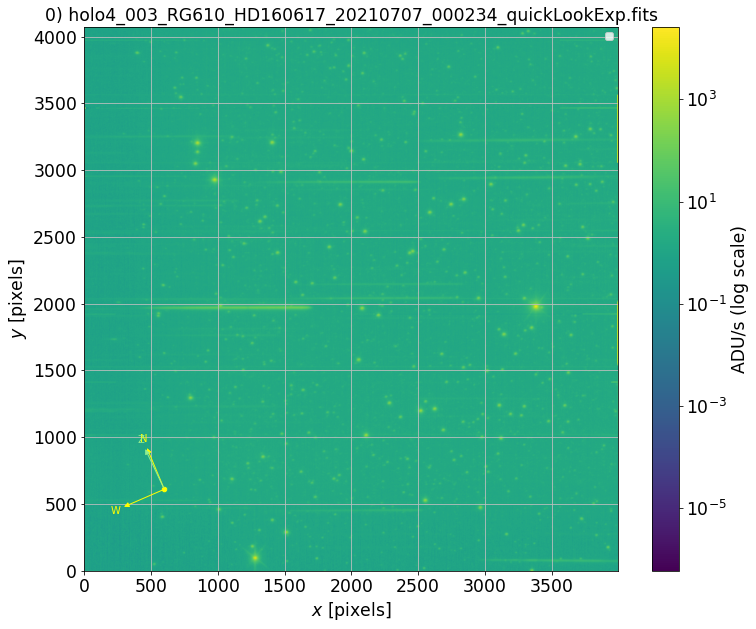

1 ... 18
------------
1   18
/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp/2021-07-07/holo4_003_empty_HD160617_20210707_000254_quickLookExp.fits


2021-09-28 15:30:37  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.351957451830463 but average of self.read_out_noise is 8.5.


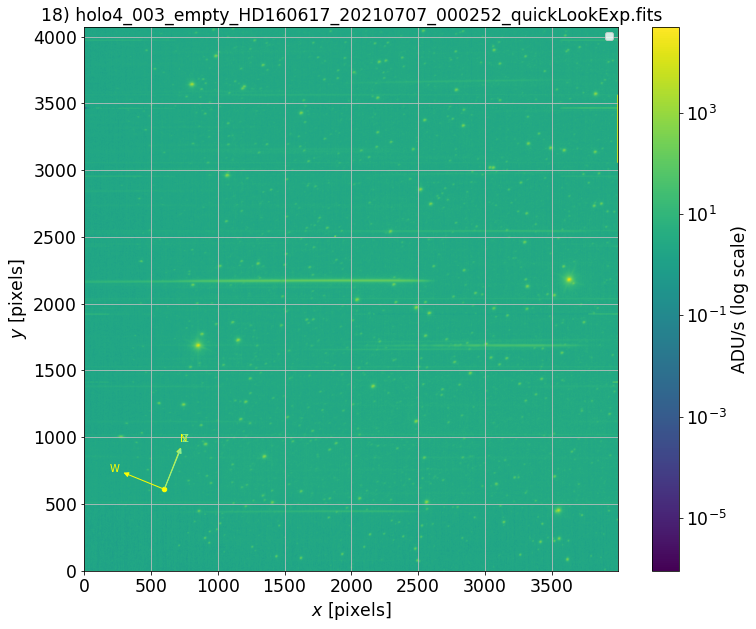

2 ... 19
------------
2   19
/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp/2021-07-07/holo4_003_empty_HD160617_20210707_000254_quickLookExp.fits


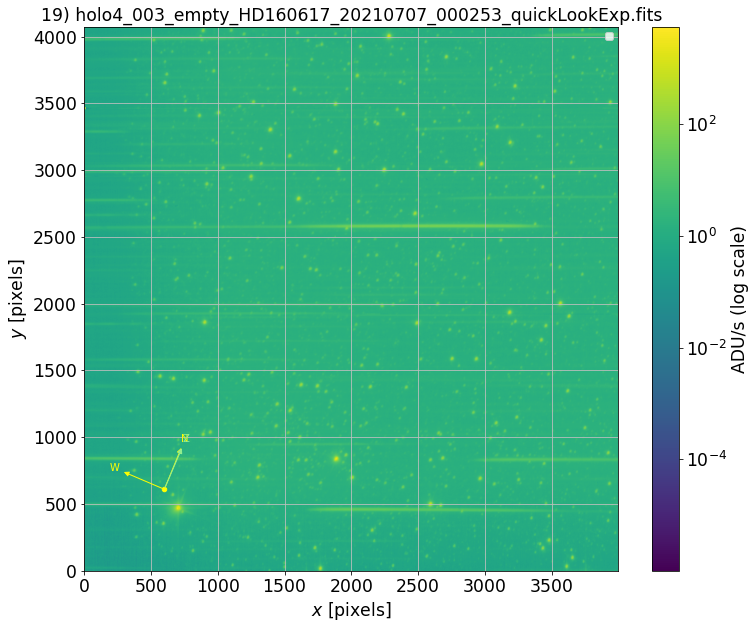

3 ... 20
------------
3   20
/Users/dagoret/DATA/AuxTelData2021/holo/quickLookExp/2021-07-07/holo4_003_empty_HD160617_20210707_000254_quickLookExp.fits


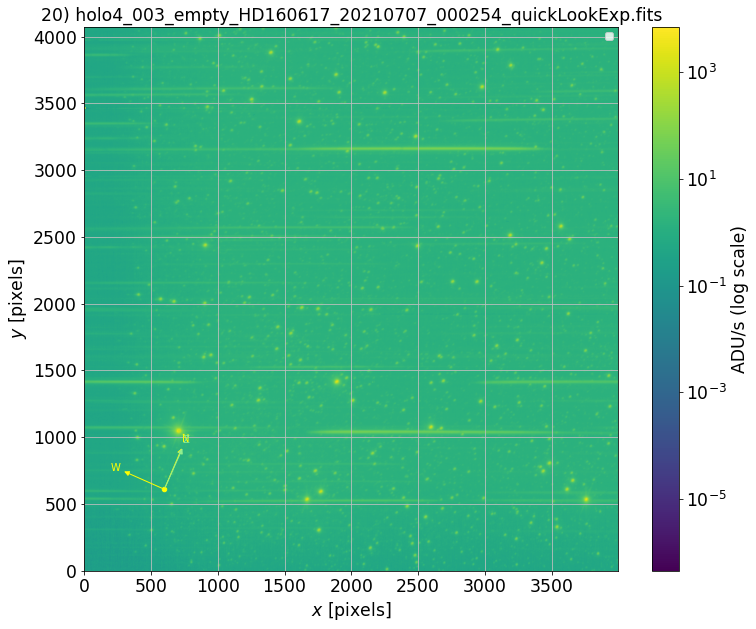

In [107]:
fig=plt.figure(figsize=(16,16))
for k in np.arange(N):
#    ax=fig.add_subplot(Nrow,Ncol,k+1)
    the_idx=all_idx[k]
    
    print(k,"...",the_idx)
    
    filename_image=df.iloc[the_idx]['file']
    
    print("------------")
    print(k," ",the_idx)
    print(fullfilename)
    
    #hdu = fits.open(fullfilename)
    image=Image(file_name=filename_image, target_label=df.iloc[the_idx]["object"], 
                disperser_label=df.iloc[the_idx]["disperser"], config=config)
    
    title="{}) {}".format(the_idx,filename_image)
    image.plot_image(figsize=(12, 10),scale="log",title=title)
    

In [58]:
alert False

SyntaxError: invalid syntax (<ipython-input-58-0039b9705ac8>, line 1)

# Transform the input file

In [ ]:
from shutil import copyfile

In [ ]:
copyfile(filename,filename_image)

In [ ]:
hdu = fits.open(filename_image)

In [ ]:
hdu.info()

In [ ]:
header=hdu[0].header
image=hdu[0].data

In [ ]:
hdu.close()

## Rotate image

In [ ]:
rot_image=np.flip(np.flip(image, 1), 0)

### Remove WCS

In [ ]:
del header['WCSAXES']
del header['CTYPE1']
del header['CTYPE2']
del header['CUNIT1']
del header['CUNIT2']
del header['CRVAL1']
del header['CRVAL2']
del header['CRPIX1']
del header['CRPIX2']

## Reshape the file for load_image_AUXTEL() in Spectractor/spectractor/extractor/images.py

In [ ]:
primary_hdu = fits.PrimaryHDU(header=header)
image_hdu = fits.ImageHDU(rot_image)

In [ ]:
hdu_list = fits.HDUList([primary_hdu, image_hdu])

In [ ]:
hdu_list.info()

In [ ]:
hdu_list.writeto(filename_image,overwrite=True)

## Load the image in the new file

In [ ]:
#image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)
image=Image(file_name=filename_image, target_label=target, disperser_label=disperser_label, config=config)

## Show relevant parameters

In [ ]:
parameters.OBS_NAME

In [ ]:
parameters.DISPERSER_DIR

In [ ]:
parameters.DISTANCE2CCD

In [ ]:
parameters.LAMBDA_MIN 

In [ ]:
parameters.LAMBDA_MAX 

In [ ]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [ ]:
image.filter_label

In [ ]:
image.header["FILTER"]

In [ ]:
#image.header

# Plot image and find the target position

In [ ]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

In [ ]:
filename_image

In [ ]:
# with filter

guess = [600., 2100.] # filename_image=df['file'][0] , holo4_003_RG610_HD160617_20210707_000234_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][1] , holo4_003_RG610_HD160617_20210707_000235_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][2] , holo4_003_RG610_HD160617_20210707_000236_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][3] , holo4_003_RG610_HD160617_20210707_000237_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][4] , holo4_003_RG610_HD160617_20210707_000238_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][5] , holo4_003_RG610_HD160617_20210707_000239_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][6] , holo4_003_RG610_HD160617_20210707_000240_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][7] , holo4_003_RG610_HD160617_20210707_000241_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][8] , holo4_003_RG610_HD160617_20210707_000242_quickLookExp.fits
guess = [600., 2100.] # filename_image=df['file'][9] , holo4_003_RG610_HD160617_20210707_000243_quickLookExp.fits
guess = [1300., 700.] # filename_image=df['file'][10] , holo4_003_RG610_HD160617_20210707_000244_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][11] , holo4_003_RG610_HD160617_20210707_000245_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][12] , holo4_003_RG610_HD160617_20210707_000246_quickLookExp.fits
guess = [250., 1800.] # filename_image=df['file'][13] , holo4_003_RG610_HD160617_20210707_000247_quickLookExp.fits


# wide scan
guess = [1400., 700.] # filename_image=df['file'][14] , holo4_003_empty_HD160617_20210707_000248_quickLookExp.fits
guess = [1400., 800.] # filename_image=df['file'][15] , holo4_003_empty_HD160617_20210707_000249_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][16] , holo4_003_empty_HD160617_20210707_000250_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][17] , holo4_003_empty_HD160617_20210707_000251_quickLookExp.fits
guess = [400., 1800.] # filename_image=df['file'][18] , holo4_003_empty_HD160617_20210707_000252_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][19] , holo4_003_empty_HD160617_20210707_000253_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][20] , holo4_003_empty_HD160617_20210707_000254_quickLookExp.fits
#guess = [50., 800.] # filename_image=df['file'][21] , holo4_003_empty_HD160617_20210707_000255_quickLookExp.fits

#

# narrrow scan

guess = [500.,2100.] # filename_image=df['file'][76] , 'holo4_003_empty_HD160617_20210707_000317_quickLookExp.fits'
guess = [500.,2100.] # filename_image=df['file'][77] , 'holo4_003_empty_HD160617_20210707_000318_quickLookExp.fits'
guess = [500.,1800.] # filename_image=df['file'][78] , 'holo4_003_empty_HD160617_20210707_000319_quickLookExp.fits'
guess = [500.,1800.] # filename_image=df['file'][79] , 'holo4_003_empty_HD160617_20210707_000320_quickLookExp.fits'
guess = [500.,1300.] # filename_image=df['file'][80] , 'holo4_003_empty_HD160617_20210707_000321_quickLookExp.fits'

In [ ]:
filename_image

In [ ]:
if FLAG_ORDER0_LOCATION : 
    print("Set Order 0 location from logbook : ({},{})".format(x0,y0))
    guess = [x0,y0]

In [ ]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [ ]:
print(x1,y1)

In [ ]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [ ]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [ ]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [ ]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [ ]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [ ]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [ ]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [ ]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [ ]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [ ]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [ ]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [ ]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [ ]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

In [ ]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title,Y=1.01)

In [ ]:
assert False

# Go for spectrum reconstruction

In [ ]:
parameters.debug=False
parameters.verbose=False
parameters.display=False
parameters.LIVE_FIT=False

In [ ]:
#spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)
spectrum = Spectractor(filename_image, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

# Remove temporary file

In [ ]:
os.remove(filename_image)

# Backup output

In [ ]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

In [ ]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))